In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

/work/uo1075/u241292/conda_envs/py37/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/work/uo1075/u241292/conda_envs/py37/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### Load data

In [2]:
# raw data
path='/work/uo1075/u241292/outputs/alvise_bandpass/'
ds = xr.open_dataset(path+'E5pl00_1H_XXXX-XX_daily_250hPa_EKE_mergetime.nc')
myvar = ds['var131'][:,0,:,:].values
lat = ds['lat']
lon = ds['lon']
time = ds['time']
# ds.info()

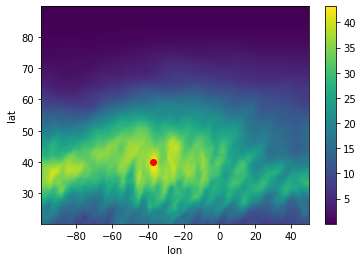

In [3]:
# Let's check what regions have high variance
plt.pcolormesh(lon, lat, np.std(myvar, axis=0))
plt.colorbar()
plt.scatter(-37,40, marker='o', c='r')
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()
# Looks like the region around 37W and 40N, for example, varies a lot

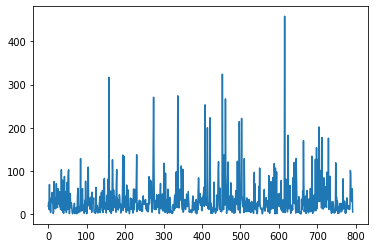

In [4]:
# Make time series of that point
pointCoords = [40, -37] # [lat, lon]
idlat = np.where(abs(pointCoords[0]-lat)==min(abs(pointCoords[0]-lat)))[0]
idlon = np.where(abs(pointCoords[1]-lon)==min(abs(pointCoords[1]-lon)))[0]
ts = np.squeeze(myvar[:, idlat, idlon])

plt.plot(ts)
plt.show()

### Lanczos low-pass filter

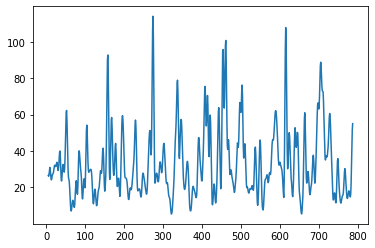

In [7]:
# https://github.com/davidmnielsen/pystuff
import pystuff as ps

ts_filt, ts_filt_noNans = ps.lanczos(ts, cutoff=10, returnNonan=True)
plt.plot(ts_filt)
plt.show()

### Compare

#### Frequencies

In [8]:
freq,   psd,   pctl,   max5,   meanRed   = ps.periods(ps.standardize(ts), dt=1, nsim=1000)
freq_f, psd_f, pctl_f, max5_f, meanRed_f = ps.periods(ps.standardize(ts_filt_noNans), dt=1, nsim=1000)

/mnt/lustre01/pf/zmaw/u241292/scripts/python/pystuff/pystuff/__init__.py:643: RuntimeWarning: divide by zero encountered in true_divide
  per=1/f


/work/uo1075/u241292/conda_envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/work/uo1075/u241292/conda_envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/work/uo1075/u241292/conda_envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/work/uo1075/u241292/conda_envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/work/uo1075/u241292/conda_envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/work/uo1075/u241292/conda_envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


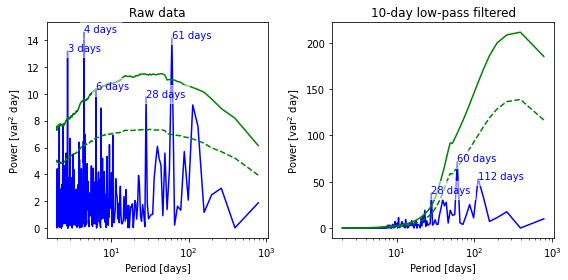

In [9]:
fig = plt.figure(figsize = (8,4))

ax = fig.add_subplot(121)
plt.plot(1/freq, psd,'b', label='Spectrum')
plt.plot(1/freq,ps.runmean(pctl[:,2], window=31, fillaround=True), '--g', label='95th Pctl')
plt.plot(1/freq,ps.runmean(pctl[:,3], window=31, fillaround=True), '-g',  label='99th Pctl')
plt.xlabel('Period [days]')
plt.ylabel('Power [var$^{2}$ day]')
plt.xscale('log')
plt.title('Raw data')
for i in range(5):
    t=plt.text(1/max5[i,0],max5[i,1],'%.0f days' %round(max5[i,2]), color='blue')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='w'))
    
ax = fig.add_subplot(122)
plt.plot(1/freq_f, psd_f,'b', label='Spectrum')
plt.plot(1/freq_f,ps.runmean(pctl_f[:,2], window=31, fillaround=True), '--g', label='95th Pctl')
plt.plot(1/freq_f,ps.runmean(pctl_f[:,3], window=31, fillaround=True), '-g',  label='99th Pctl')
plt.xlabel('Period [days]')
plt.ylabel('Power [var$^{2}$ day]')
plt.title('10-day low-pass filtered')
for i in range(3):
    t=plt.text(1/max5_f[i,0],max5_f[i,1],'%.0f days' %round(max5_f[i,2]), color='blue')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='w'))
plt.xscale('log')

plt.tight_layout()
plt.show()

fig.savefig('periodograms.png', dpi=300)

#### Time series

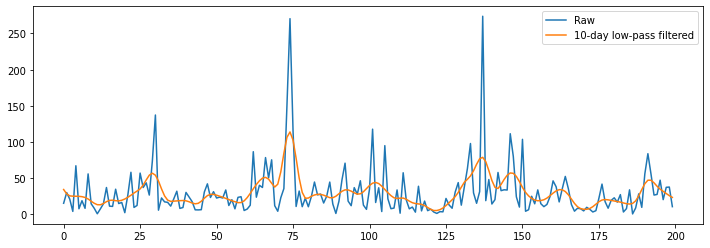

In [13]:
fig = plt.figure(figsize = (12,4))
ax = fig.add_subplot(111)
plt.plot(ts[200:400], label='Raw')
plt.plot(ts_filt[200:400], label='10-day low-pass filtered')
plt.legend()
plt.show()